In [ ]:
# Import dependencies
import string
import re
import os
import time
import numpy as np
from numpy import array
import pandas as pd
from collections import Counter
from random import randint
from pickle import load, dump

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Mount point for Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Save in Colab
# /content/sample_data/train.csv
os.getcwd()
%cd /content/gdrive/My\ sample_data/train.csv
!pwd
# !ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/sample_data/train.csv"

[Errno 2] No such file or directory: '/content/gdrive/My sample_data/train.csv'
/content
/content
Working Directory
/content


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data load, pre-processing, and exploration
Pre-processing steps involve the following:
* Loading the text document
* Cleaning the document (lower-casing, removal of punctuation, tokenization)
* Saving a clean copy of the text

Exploratory data analysis is conducted as well:
* Outputting most- and least-frequent tokens (with and without stopwords removed) to explore word frequencies 
* Bigram counts to explore which two-word pairs of words occur frequently. This can help reveal (potentially) more meaningful frequencies than single words simply as they appear on their own in the text.
* Defining a function for lexical diversity and calculating it for the text as is, and also with stopwords removed. Lexical diversity refers to the range of different words used in a text. Its meaning is text-dependent and not a perfect reflection, however it gives an indication of the scope of different kinds of words in the text; a greater range (higher number) may indicate higher diversity. It is the number of unique tokens in a text as a proportion of total tokens, calculated as follows:

$$
\frac{len(set(text)}{len(text)}
$$

In [ ]:
# Define function to load document into memory
def load_doc(filename):
    # Open the file as read only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

In [ ]:
# Load document
# /content/gdrive/MyDrive/Colab Notebooks/MSDS 458/Final Project/disasters/train.csv
in_filename = '/content/gdrive/MyDrive/Colab Notebooks/MSDS 458/Final Project/disasters/train.csv'
doc = load_doc(in_filename)
print(doc[:1000])

id,keyword,location,text,target
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,,,Forest fire near La Ronge Sask. Canada,1
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,,,"13,000 people receive #wildfires evacuation orders in California ",1
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ,1
8,,,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
10,,,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
13,,,I'm on top of the hill and I can see a fire in the woods...,1
14,,,There's an emergency evacuation happening now in the building across the street,1
15,,,I'm afraid that the tornado is coming to our area...,1
16,,,Three people died from the heat wave so far,1
17,,,Haha South Tampa is getting flooded hah- WAIT 

### 1. Clean text

In [ ]:
# Define function for turning document into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [ ]:
# Clean document and output total and unique values
tokens = clean_doc(doc)
vocab = set(tokens)
print(tokens[:200])
print('---------------------------------------')
print('Total tokens: %d' % len(tokens))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens)))

['idkeywordlocationtexttarget', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'fire', 'near', 'la', 'ronge', 'sask', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'a', 'school', 'update', 'california', 'hwy', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'county', 'fire', 'cafire', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'of', 'streets', 'in', 'manitou', 'colorado', 'springs', 'on', 'top', 'of', 'the', 'hill', 'and', 'i', 'can', 'see', 'a', 'fire', 'in', 'the', 'an', 'emergency', 'evacuation', 'happening', 'now', 'in', 'the', 'building', 'across', 'the', 'afraid', 'that', 'the', 'tornado', '

### 2. Exploratory data analysis

In [ ]:
# Define functions for lexical diversity and percentage of total
def lexical_diversity(text):
    return len(set(text)) / len(text) 

def percentage(count, total):   
    return 100 * count / total

In [ ]:
lexical_diversity(tokens)

0.17304935490477166

In [ ]:
# Plot word frequency
# Initialize a dictionary
dict = {}

# Count number of times each word comes up in list of words
for key in tokens: 
    dict[key] = dict.get(key, 0) + 1

counts = sorted(dict.items(), key = lambda x: x[1], reverse = True)

In [ ]:
# Most and least frequent word occurence
top_counts = counts[:30]
least_counts = counts[-30:]

In [ ]:
print('top_counts:', top_counts)
print('--------------------------')
print('least_counts:', least_counts)

top_counts: [('the', 3119), ('a', 2116), ('in', 1996), ('to', 1947), ('of', 1895), ('and', 1433), ('i', 1097), ('is', 935), ('for', 888), ('on', 845), ('you', 749), ('my', 633), ('with', 577), ('at', 536), ('that', 524), ('by', 521), ('it', 506), ('from', 427), ('this', 426), ('are', 400), ('be', 397), ('was', 380), ('have', 377), ('like', 339), ('as', 324), ('but', 307), ('up', 304), ('amp', 297), ('your', 294), ('just', 293)]
--------------------------
least_counts: [('chances', 1), ('mtmarynmck', 1), ('adorable', 1), ('glasgow', 1), ('caitsroberts', 1), ('barra', 1), ('nykirafrog', 1), ('mountwario', 1), ('texashad', 1), ('bright', 1), ('goner', 1), ('cameronhacker', 1), ('canadathree', 1), ('shoutout', 1), ('fx', 1), ('gig', 1), ('httptcoaawzxykles', 1), ('boxes', 1), ('exploding', 1), ('kittens', 1), ('gameofkittens', 1), ('iwate', 1), ('ayyo', 1), ('explosivespacked', 1), ('vest', 1), ('overtaking', 1), ('bathandnortheastsomerset', 1), ('forney', 1), ('developing', 1), ('symptoms

**Figure 1: 30 most frequently occurring tokens in text**

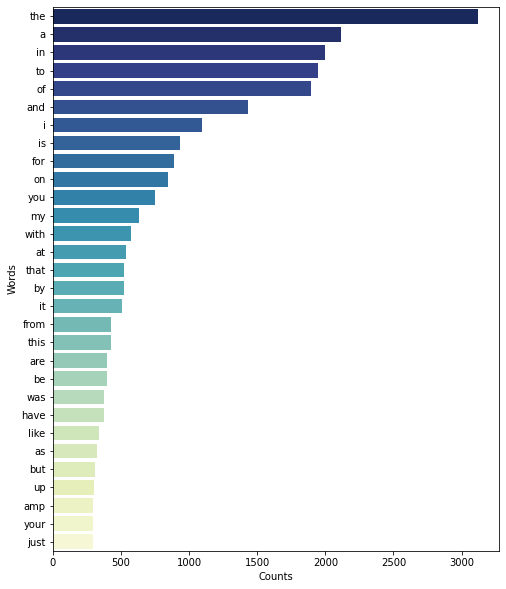

In [ ]:
# Plot frequencies
words_plot = pd.DataFrame(top_counts, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot, palette = "YlGnBu_r")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Function to create clean doc with stopwords removed
def clean_doc_sw(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    # stop_words = nltk.corpus.stopwords.words('english')
    newStopWords = ['i','the','he','on','shall']
    stop_words.update(newStopWords)
    tokens = [w for w in tokens if not w in stop_words]
    return tokens

In [ ]:
# clean document
tokens_sw = clean_doc_sw(doc)
print(tokens_sw[:200])
print('Total tokens: %d' % len(tokens_sw))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens_sw)))

['idkeywordlocationtexttarget', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us', 'fire', 'near', 'la', 'ronge', 'sask', 'residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'california', 'got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'top', 'hill', 'see', 'fire', 'emergency', 'evacuation', 'happening', 'building', 'across', 'afraid', 'tornado', 'coming', 'people', 'died', 'heat', 'wave', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gonna', 'gonna', 'fvck', 'flooding', 'florida', 'tampabay', 'tampa', 'days', 'ive', 'lost', 'count', 'bago', 'myanmar', 'arrived', 'school', 'bus'

In [ ]:
lexical_diversity(tokens_sw)

0.2624724096366682

In [ ]:
# Plot word frequency
# Initialize a dictionary
dict_sw = {}

# Count number of times each word comes up in list of words
for key in tokens_sw: 
    dict_sw[key] = dict_sw.get(key, 0) + 1

counts_sw = sorted(dict_sw.items(), key = lambda x: x[1], reverse = True)

In [ ]:
# Most and least frequent word occurence
top_counts_sw = counts_sw[:30]
least_counts_sw = counts_sw[-30:]

In [ ]:
print('top_counts with stopwords removed:', top_counts_sw)
print('--------------------------')
print('least_counts with stopwords removed:', least_counts_sw)

top_counts with stopwords removed: [('like', 339), ('amp', 297), ('im', 239), ('via', 228), ('get', 225), ('fire', 215), ('new', 209), ('people', 180), ('one', 170), ('dont', 165), ('news', 146), ('emergency', 139), ('us', 138), ('disaster', 138), ('would', 129), ('video', 129), ('still', 120), ('police', 118), ('body', 116), ('crash', 115), ('burning', 111), ('know', 110), ('california', 107), ('got', 107), ('back', 107), ('storm', 106), ('buildings', 105), ('see', 99), ('day', 99), ('first', 98)]
--------------------------
least_counts with stopwords removed: [('chances', 1), ('mtmarynmck', 1), ('adorable', 1), ('glasgow', 1), ('caitsroberts', 1), ('barra', 1), ('nykirafrog', 1), ('mountwario', 1), ('texashad', 1), ('bright', 1), ('goner', 1), ('cameronhacker', 1), ('canadathree', 1), ('shoutout', 1), ('fx', 1), ('gig', 1), ('httptcoaawzxykles', 1), ('boxes', 1), ('exploding', 1), ('kittens', 1), ('gameofkittens', 1), ('iwate', 1), ('ayyo', 1), ('explosivespacked', 1), ('vest', 1), (

**Figure 2: 30 most frequently occurring tokens in text, stopwords removed**

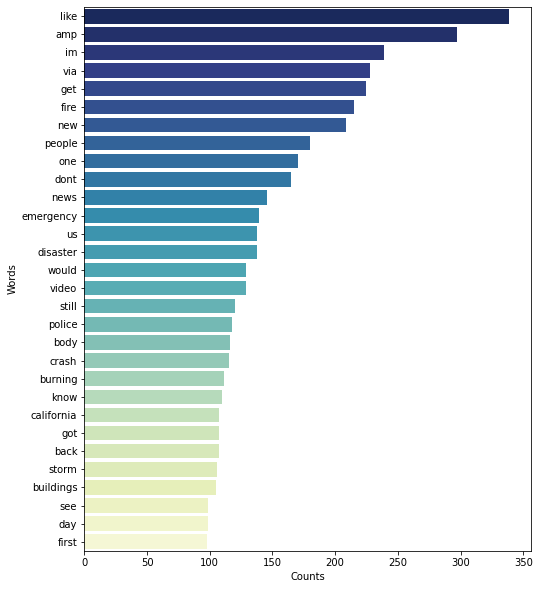

In [ ]:
# Plot frequencies
words_plot_sw = pd.DataFrame(top_counts_sw, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot_sw, palette = "YlGnBu_r")

In [ ]:
# Explore longer words, potentially as a signal for more "meaningful" words. Notice that some of these words
# were compound phrases and adjectives, such as "cucumberframe," which appears in the text as "cucumber-frame."
V = set(tokens)
long_words = [w for w in V if len(w) > 10]
print('Unique words over 10 characters:', len(long_words))
print('--------------------------------')
sorted(long_words)

In [ ]:
# Bigram analysis
bigram_list = list(nltk.bigrams(tokens))

# Display number of total bigrams and number of unique bigrams
print('Total bigrams across text: ' + str(len(bigram_list)))
print('Unique bigrams across text: ' + str(len(set(bigram_list))))

Total bigrams across text: 97659
Unique bigrams across text: 63656


In [ ]:
# Plot word frequency
# Initialize a dictionary
dict_bigrams = {}

# Count number of times each word comes up in list of words
for key in bigram_list: 
    dict_bigrams[key] = dict_bigrams.get(key, 0) + 1

counts_bigrams = sorted(dict_bigrams.items(), key = lambda x: x[1], reverse = True)

In [ ]:
# Most and least frequent word occurence
top_counts_bigrams = counts_bigrams[:30]
least_counts_bigrams = counts_bigrams[-30:]

In [ ]:
print('top occuring bigrams:', top_counts_bigrams)
print('--------------------------')
print('least occuring bigrams:', least_counts_bigrams)

top occuring bigrams: [(('in', 'the'), 316), (('of', 'the'), 266), (('to', 'the'), 135), (('on', 'the'), 124), (('in', 'a'), 114), (('to', 'be'), 110), (('for', 'the'), 99), (('like', 'a'), 87), (('at', 'the'), 84), (('and', 'the'), 80), (('is', 'a'), 76), (('is', 'the'), 66), (('by', 'the'), 66), (('of', 'a'), 62), (('for', 'a'), 62), (('by', 'a'), 59), (('to', 'a'), 59), (('going', 'to'), 57), (('have', 'been'), 55), (('a', 'youtube'), 55), (('with', 'a'), 54), (('and', 'i'), 52), (('to', 'get'), 52), (('more', 'than'), 51), (('i', 'was'), 50), (('will', 'be'), 50), (('i', 'dont'), 49), (('have', 'a'), 48), (('i', 'just'), 48), (('out', 'of'), 47)]
--------------------------
least occuring bigrams: [(('tornado', 'warning'), 1), (('warning', 'say'), 1), (('an', 'alabama'), 1), (('case', 'after'), 1), (('after', 'developing'), 1), (('developing', 'symptoms'), 1), (('symptoms', 'fallen'), 1), (('tr', 'the'), 1), (('the', 'flip'), 1), (('flip', 'side'), 1), (('side', 'im'), 1), (('at', '

**Figure 3: 30 most frequently occurring bi-grams in text**

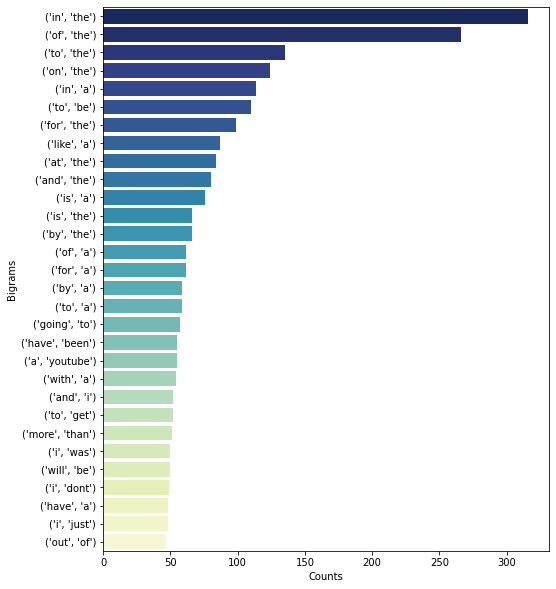

In [ ]:
# Plot frequencies
bigrams_plot = pd.DataFrame(top_counts_bigrams, columns = ['Bigrams', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Bigrams", x="Counts", data=bigrams_plot, palette = "YlGnBu_r")

In [ ]:
# # Find most frequently occurring bigrams (top 30)
# counter=Counter(bigram_list)
# # print(counter.most_common(30))
# print('Most common bigrams: ' + '\n' + str(counter.most_common(30)))

## 3. Save clean text as sequences and load document into memory
Sequence length is a key design decision: they must be long enough to properly allow models to learn the context and make reasonable predictions. The sequence length also defines the seed text length used to generate text sequences for model evaluation. A length of 50 is selected for this study, with sequences serving as inputs and training patterns to the various models. 

In [ ]:
# Organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # Select sequence of tokens
    seq = tokens[i-length:i]
    # Convert into a line
    line = ' '.join(seq)
    # Store
    sequences.append(line)
print('Total sequences: %d' % len(sequences))

Total sequences: 97609


In [ ]:
# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
# Save sequences to file
out_filename = 'alice_sequences.txt'
save_doc(sequences, out_filename)

TypeError: ignored

In [ ]:
# Define function to load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [ ]:
# Load doc
in_filename = '/content/gdrive/MyDrive/Colab Notebooks/MSDS 458/Final Project/disasters/train.csv'
doc = load_doc(in_filename)
lines = doc.split('\n')

## 4. Prepare data sequences for neural network input

The Tokenizer class in Keras is used to encode input sequences to integers, which the neural networks expect as input. The vocabulary size, defined by this encoding process, is defined as the vocabulary + 1 in length for feeding to the Embedding layer. After encoding, sequences are separated into input (X) and output (y) elements using array slicing. Output words are one hot encoded so the models in the study can predict the probability distribution for the next word.

In [ ]:
# Integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

16901

In [ ]:
# Separate sequences into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [ ]:
print('Total Sequences: %d' % len(sequences))

Total Sequences: 97609


## 5. Train language models

To train statistical models from the data, these experiments all employ an embedding layer to learn the representation of words. Parameterization of words as vectors in this manner, learned as part of the training process, enables words with a similar meaning to have a similar representation. LSTM RNNs then learn to predict words based on context. There is no test dataset: models are trained on the entire training dataset to learn the probability of each word in a sequence.

All models will employ the following hyperparameters for consistency and evaluation purposes:
* Loss function: categorical cross-entropy
* Optimizer: adam
* Batch size: 128
* Training epochs: 50
* Early stopping with patience of 5

### <i>Baseline experiment 1: LSTM RNN</i> 
This first neural network serves as a baseline, with a simple architecture and fewer memory cell units, to evaluate model performance on this text with a relatively spare neural network.
* 1 hidden layer
* 100 memory cell units
* Embedding vector space size 50

In [ ]:
# Define model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 50, input_length=seq_length))
model_1.add(LSTM(100))
# model_1.add(LSTM(100))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(vocab_size, activation='softmax'))

In [ ]:
!pwd

/content


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            845050    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 16901)             1707001   
                                                                 
Total params: 2,622,551
Trainable params: 2,622,551
Non-trainable params: 0
_________________________________________________________________


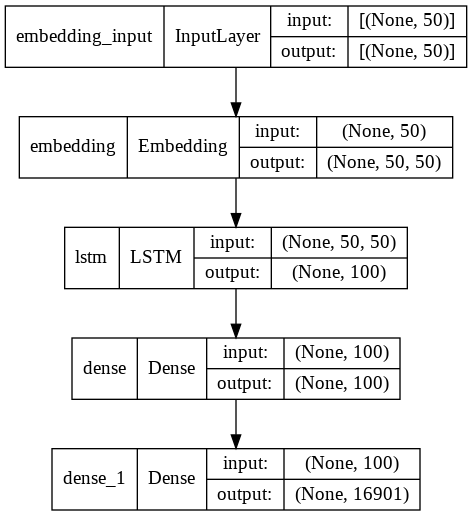

In [ ]:
# Model summary
model_1.summary()
plot_model(model_1, to_file='/content/gdrive/MyDrive/Colab Notebooks/MSDS 458/Final Project/disasters/model_1.png', show_shapes=True)

#/content/gdrive/MyDrive/Colab Notebooks/MSDS 458/Final Project/disasters

In [ ]:
# Compile model
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
# filepath='results/exp1/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp1/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_1.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Epoch 1/50
760/763 [============================>.] - ETA: 0s - loss: 7.9497 - accuracy: 0.0318
Epoch 00001: loss improved from inf to 7.94942, saving model to results/exp1/best_model.hdf5
763/763 [==============================] - 16s 15ms/step - loss: 7.9494 - accuracy: 0.0318
Epoch 2/50
761/763 [============================>.] - ETA: 0s - loss: 7.5509 - accuracy: 0.0405
Epoch 00002: loss improved from 7.94942 to 7.55085, saving model to results/exp1/best_model.hdf5
763/763 [==============================] - 12s 15ms/step - loss: 7.5508 - accuracy: 0.0405
Epoch 3/50
762/763 [============================>.] - ETA: 0s - loss: 7.2455 - accuracy: 0.0496
Epoch 00003: loss improved from 7.55085 to 7.24536, saving model to results/exp1/best_model.hdf5
763/763 [==============================] - 12s 15ms/step - loss: 7.2454 - accuracy: 0.0496
Epoch 4/50
761/763 [============================>.] - ETA: 0s - loss: 6.9392 - accuracy: 0.0609
Epoch 00004: loss improved from 7.24536 to 6.93941, savi

In [ ]:
# Plot model performance

In [ ]:
# history_dict = history.history
# history_dict.keys()

**Figure 4: Learning curves for Model 1**

FileNotFoundError: ignored

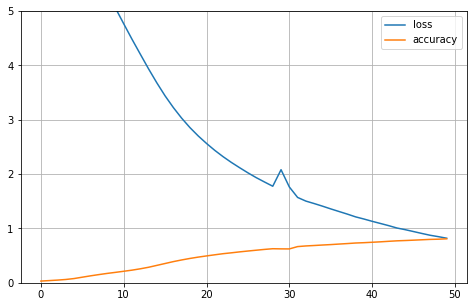

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-5]
plt.savefig('figures/learning_curves_model_1', tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_1.save('results/exp1/model_1.h5')
# Save the tokenizer
dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model
model = load_model('results/exp1/model_1.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Define function to generate sequence from language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: a youtube video from itsjustinstuart gun range streetnosurrender results full metal mayhem world title match bully ray taken out a career comes to an end and more universeltmeltdown of proportions commences i manage to calm myself long enough to turn the waters to hot and wait for the steam to cloud
----------------------------------


AttributeError: ignored

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()

### <i>Experiment 2: LSTM RNN </i>
This neural network differs from the baseline with additional memory cell units.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [ ]:
# Define model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 50, input_length=seq_length))
model_2.add(LSTM(256))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(vocab_size, activation='softmax'))

In [ ]:
# Model summary
model_2.summary()
plot_model(model_2, to_file='figures/model_2.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            845050    
                                                                 
 lstm_1 (LSTM)               (None, 256)               314368    
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dense_3 (Dense)             (None, 16901)             1707001   
                                                                 
Total params: 2,892,119
Trainable params: 2,892,119
Non-trainable params: 0
_________________________________________________________________


FileNotFoundError: ignored

In [ ]:
# Compile model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
# filepath='results/exp2/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp2/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint,es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_2.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Epoch 1/50
761/763 [============================>.] - ETA: 0s - loss: 7.9713 - accuracy: 0.0314
Epoch 00001: loss improved from inf to 7.97139, saving model to results/exp2/best_model.hdf5
763/763 [==============================] - 16s 18ms/step - loss: 7.9714 - accuracy: 0.0314
Epoch 2/50
762/763 [============================>.] - ETA: 0s - loss: 7.5652 - accuracy: 0.0407
Epoch 00002: loss improved from 7.97139 to 7.56537, saving model to results/exp2/best_model.hdf5
763/763 [==============================] - 14s 18ms/step - loss: 7.5654 - accuracy: 0.0407
Epoch 3/50
762/763 [============================>.] - ETA: 0s - loss: 7.3247 - accuracy: 0.0470
Epoch 00003: loss improved from 7.56537 to 7.32459, saving model to results/exp2/best_model.hdf5
763/763 [==============================] - 14s 18ms/step - loss: 7.3246 - accuracy: 0.0470
Epoch 4/50
762/763 [============================>.] - ETA: 0s - loss: 7.0561 - accuracy: 0.0545
Epoch 00004: loss improved from 7.32459 to 7.05652, savi

In [ ]:
# Plot model performance

SyntaxError: ignored

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

**Figure 5: Learning curves for Model 2**

FileNotFoundError: ignored

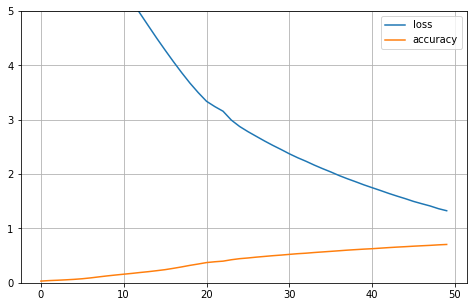

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_2', tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_2.save('results/exp2/model_2.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model - use name from best model
model = load_model('results/exp2/model_2.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()

### <i>Experiment 3: LSTM RNN </i>
This deeper neural network adds a hidden layer to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 100 memory cell units
* Embedding vector space size 50

In [ ]:
# Define model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 50, input_length=seq_length))
model_3.add(LSTM(100, return_sequences=True))
model_3.add(LSTM(100))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(vocab_size, activation='softmax'))

In [ ]:
# Model summary
model_3.summary()
plot_model(model_3, to_file='figures/model_3.png', show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            845050    
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 16901)             1707001   
                                                                 
Total params: 2,702,951
Trainable params: 2,702,951
Non-trainable params: 0
_________________________________________________________________


FileNotFoundError: ignored

In [ ]:
# Compile model
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
filepath='results/exp3/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_3.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

In [ ]:
 # Plot model performance

In [ ]:
# history_dict = history.history
# history_dict.keys()

**Figure 6: Learning curves for Model 3**

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 8) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_3.save('results/exp3/model_3.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model - use name from best model
model = load_model('results/exp3/model_3.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()

### <i>Experiment 4: LSTM RNN with 2 hidden layers and additional memory cell units</i>
This deeper neural network adds memory cell units to the architecture of the model from Experiment 3 to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 256 memory cell units
* Embedding vector space size 50

In [ ]:
# Define model
model_4 = Sequential()
model_4.add(Embedding(vocab_size, 50, input_length=seq_length))
model_4.add(LSTM(256, return_sequences=True))
model_4.add(LSTM(256))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(vocab_size, activation='softmax'))

In [ ]:
# Model summary
model_4.summary()
plot_model(model_4, to_file='figures/model_4.png', show_shapes=True)

In [ ]:
# Compile model
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
filepath='results/exp4/est_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_4.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

In [ ]:
# Plot model performance

In [ ]:
# history_dict = history.history
# history_dict.keys()

**Figure 7: Learning curves for Model 4**

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_4', tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_4.save('results/exp4/model_4.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model - use name from best model
model = load_model('results/exp4/model_4.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()

### <i>Experiment 5: LSTM RNN with larger embedding vector space</i>
This experiment takes the best model from Experiment 4, with 2 hidden layers and 256 memory cell units, and tests the increased embedding vector space on performance and interpretability.
* 2 hidden layers
* 100 memory cell units
* Embedding vector space size 100

In [ ]:
# Define model
model_5 = Sequential()
model_5.add(Embedding(vocab_size, 100, input_length=seq_length))
model_5.add(LSTM(256))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(vocab_size, activation='softmax'))

In [ ]:
# Model summary
model_5.summary()
plot_model(model_5, to_file='figures/model_5.png', show_shapes=True)

In [ ]:
# Compile model
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
filepath='results/exp5/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
callbacks_list = [checkpoint, es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_5.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

In [ ]:
# Plot model performance

In [ ]:
# history_dict = history.history
# history_dict.keys()

**Figure 8: Learning curves for Model 5**

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_5', tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_5.save('results/exp5/model_5.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model - use name from best model
model = load_model('results/exp5/model_5.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

In [ ]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()

### <i>Experiment 6: Bidirectional LSTM with 1 HL and 50% dropout</i>
This final experiment employs a Bidirectional LSTM and 50 percent dropout to evaluate WHAT.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [ ]:
# Define model
model_6 = Sequential()
model_6.add(Embedding(vocab_size, 50, input_length=seq_length))
model_6.add(Bidirectional(LSTM(256)))
model_6.add(Dropout(0.5))
# model_6.add(LSTM(256))
# model_6.add(Dense(256, activation='relu'))
model_6.add(Dense(vocab_size, activation='softmax'))

In [ ]:
# Model summary
model_6.summary()
plot_model(model_6, to_file='figures/model_6.png', show_shapes=True)

In [ ]:
# Compile model
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the checkpoint
filepath='results/exp6/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Fit the model
start_time = time.time()
history = model_6.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

In [ ]:
# Plot model performance

In [ ]:
# history_dict = history.history
# history_dict.keys()

**Figure 9: Learning curves for Model 6**

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_6', tight_layout=False)
plt.show()

In [ ]:
# Save the model to file
model_6.save('results/exp6/model_6.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [ ]:
# Prepare the language model

In [ ]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [ ]:
# Load the model - use name from best model
model = load_model('results/exp6/model_6.h5')

In [ ]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [ ]:
# Generate text and evaluate

In [ ]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

In [ ]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

In [ ]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [ ]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

In [ ]:
tf.keras.backend.clear_session()